<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/IPS_Chalenge_BERT_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers

     |████████████████████████████████| 573kB 2.8MB/s 
     |████████████████████████████████| 3.7MB 52.3MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
     |████████████████████████████████| 1.0MB 49.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=95feb5e208a1ac5a2289d1b959eda8f71b0aee5f46eca54671fde74f46658d70
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from sklearn.linear_model import LinearRegression

Importing the dataset

In [6]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


,"”Id""",Subject,Description,Category,Subcategory
0,NTAwMUowMDAwMGFCeXhl,PMIC workaround not performed and PMIC ID reco...,"Hi , The PMIC ID recognized wrong during the B...",Firmware/BIOS,BIOS
1,NTAwMUowMDAwMFNzNGc1,Bluetooth test fails with HLK of Windows 10 RS 2,The following Bluetooth test fails with HLK of...,Networking/Connectivity,Bluetooth (BT)
2,NTAwMUowMDAwMFRXRUpV,[ FTS ] During Windows reboot tests the system...,During Windows reboot tests the system with VM...,Software/Driver/OS,Tool
3,NTAwMUowMDAwMGNna0F0,Avalon arbitration using multiple SG - DMA,Error Msg : I am attempting to run a Nios II s...,DesignTools,Qsys System Design
4,NTAwMUowMDAwMGtEblFB,Is the WAV 654 support SKY 85755 + SKY 85337 ?,"Hi Intel , Can we use SKY 85755 and SKY 85337 ...",Hardware/Platform,Design Review


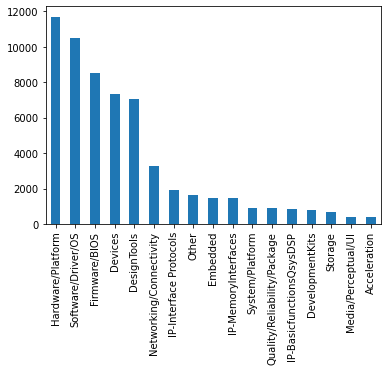

In [7]:
# Import Training, Validation and Test csvs
# report1585718073300_v6_test.csv, report1585718073300_v6_train.csv, report1585718073300_v6_val.csv
data_training = pd.read_csv(r"/gdrive/My Drive/IL/report1585718073300_v6_train.csv")
data_test = pd.read_csv(r"/gdrive/My Drive/IL/report1585718073300_v6_test.csv")

text_col=data_training.columns.values[2] 
category_col=data_training.columns.values[3]

# Filter data with NaN in Case Description or Case Category rows
data_training= data_training[data_training[category_col].notnull() & data_training[text_col].notnull()]
data_test= data_test[data_test[category_col].notnull() & data_test[text_col].notnull()]

data_training=data_training[~data_training[category_col].str.match('Technology/Initiative') & ~data_training[category_col].str.match('Power/Thermal/Mechanical')]
data_test=data_test[~data_test[category_col].str.match('Technology/Initiative') & ~data_test[category_col].str.match('Power/Thermal/Mechanical')]

data_test[category_col].value_counts().plot.bar()
data_test.head()

Init and set data

In [0]:
TRAINING_RANDOM_STATE=42
TEST_RANDOM_STATE=42

TRAINING_SAMPLE_SIZE = 90720
TEST_SAMPLE_SIZE = 10240

max_bert_len = 70

BATCH_SIZE=128
EPOCHS =10
HIDDEN_SIZE=768
EMB_DIM=100


catagories = list(set(data_training[category_col].unique()))

OUTPUT_DIM= len(catagories)   #num of catagories

In [0]:
catagories1 = list(set(data_training[category_col].unique()))

In [0]:
catagories1

['Quality/Reliability/Package',
 'Firmware/BIOS',
 'DesignTools',
 'Software/Driver/OS',
 'Networking/Connectivity',
 'Embedded',
 'IP-MemoryInterfaces',
 'System/Platform',
 'IP-Interface Protocols',
 'DevelopmentKits',
 'Hardware/Platform',
 'Power/Thermal/Mechanical',
 'Other',
 'Acceleration',
 'Technology/Initiative',
 'Storage',
 'IP-BasicfunctionsQsysDSP',
 'Devices',
 'Media/Perceptual/UI']

In [9]:
batch_training = data_training.sample(n=TRAINING_SAMPLE_SIZE, random_state=TRAINING_RANDOM_STATE);
batch_test = data_test.sample(n=TEST_SAMPLE_SIZE, random_state=TEST_RANDOM_STATE);

train_texts = batch_training[text_col]
test_texts =  batch_test[text_col]
train_labels = batch_training[category_col]
test_labels =  batch_test[category_col]

len(train_texts), len(test_texts), len(train_labels), len(test_labels)


(90720, 10240, 90720, 10240)

1. Ngram baseline model

In [10]:
#CounterVecorizer(ngram_range=(1,3), min_df=0.2, max_df=0.7, max_features=10000, stop_words="english")
#ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,2),stop_words="english",max_features=30000, max_df=0.75), LogisticRegression()).fit(train_texts, train_labels)
ngramCount_baseline_predicted = ngramCount_baseline_model.predict(test_texts)
print(classification_report(test_labels, ngramCount_baseline_predicted))
print(confusion_matrix(test_labels, ngramCount_baseline_predicted))

                             precision    recall  f1-score   support

               Acceleration       0.67      0.43      0.53        67
                DesignTools       0.74      0.78      0.76      1206
            DevelopmentKits       0.64      0.50      0.56       119
                    Devices       0.70      0.76      0.73      1261
                   Embedded       0.72      0.60      0.66       263
              Firmware/BIOS       0.66      0.64      0.65      1504
          Hardware/Platform       0.66      0.78      0.72      1979
   IP-BasicfunctionsQsysDSP       0.55      0.37      0.44       123
     IP-Interface Protocols       0.71      0.55      0.62       337
        IP-MemoryInterfaces       0.75      0.66      0.71       240
        Media/Perceptual/UI       0.72      0.39      0.51        74
    Networking/Connectivity       0.61      0.48      0.54       562
                      Other       0.55      0.34      0.42       297
Quality/Reliability/Package      

2. BERT Fine-tune

Load BERT pre-trained model

In [0]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

## Want Roberta instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
BertModel = model_class.from_pretrained(pretrained_weights)

Tokenization

In [0]:
import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
tokenized_training = batch_training[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = batch_test[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Limit tokenized to max_bert_len

In [0]:
#padded = np.array([if (len(i)>0) i=3, for i in tokenized.values])
tokenized_limted_training = []
for i in tokenized_training.values:
  if len(i)>max_bert_len:
    tokenized_limted_training.append(i[:max_bert_len])
  else:
    tokenized_limted_training.append(i)

tokenized_limted_test = []
for i in tokenized_test.values:
  if len(i)>max_bert_len:
    tokenized_limted_test.append(i[:max_bert_len])
  else:
    tokenized_limted_test.append(i)
     


Padding 

In [0]:
padded_training = np.array([i + [0]*(max_bert_len-len(i)) for i in tokenized_limted_training])
padded_test = np.array([i + [0]*(max_bert_len-len(i)) for i in tokenized_limted_test])

Our dataset is now in the `padded` variable, we can view its dimensions below:

Masking

In [41]:
attention_mask_training = np.where(padded_training != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)

attention_mask_training.shape
attention_mask_test.shape

(10240, 70)

Convert to tensors

In [0]:
train_tokens_tensor = torch.tensor(padded_training)  
train_masks_tensor = torch.tensor(attention_mask_training)

test_tokens_tensor = torch.tensor(padded_test)  
test_masks_tensor = torch.tensor(attention_mask_test)

**And now Deep Learning**

Biniarizatiom

In [0]:
# Training (Note: must check the categories align between training and testing)
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_training[[category_col]].values]
bin_catagories = mlb.fit_transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

train_y_tensor=torch.max(target_tensor_bin,1)[1]

#Test
#mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(catos) & set(catagories) for catos in batch_test[[category_col]].values]
bin_catagories = mlb.transform(data_labels)
target_tensor_bin = torch.tensor(bin_catagories.tolist())

test_y_tensor=torch.max(target_tensor_bin,1)[1]

Dataloader 

In [0]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

Define model

In [0]:
class BertMultiClassifier(torch.nn.Module):
    def __init__(self, dropout=0.1):
        super(BertMultiClassifier, self).__init__()
        # Need to define the right layer 
        self.bert = model_class.from_pretrained(pretrained_weights)
        #self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(HIDDEN_SIZE, OUTPUT_DIM)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        last_hidden_states = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = last_hidden_states[0][:,0,:]
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output) # Logits 
        proba = self.sigmoid(linear_output) # ???
        return linear_output

In [0]:
bert_clf = BertMultiClassifier()
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-5)   # learning rates: 3e-4, 1e-4, 5e-5, 3e-5
criterion = torch.nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss.  Check BCEWithLogitsLoss()

In [0]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        probas = bert_clf(token_ids, masks)
        
        batch_loss = criterion(probas, labels)
        train_loss += batch_loss.item()
               
        bert_clf.zero_grad()
        batch_loss.backward()
        
        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        #clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(train_y_tensor) / BATCH_SIZE, train_loss / (step_num + 1)))
 

    bert_clf.eval()
    bert_predicted = []
    labels_y = []
    with torch.no_grad():
      for step_num_eval, batch_data in enumerate(test_dataloader):

          token_ids, masks, labels = tuple(t for t in batch_data)

          probas = bert_clf(token_ids, masks)
        
          bert_predicted += list(torch.max(probas,1)[1])  
          print('Eval: ', epoch_num + 1)
          print("{0}/{1}".format(step_num_eval, len(test_y_tensor) / BATCH_SIZE))
 
    print(classification_report(test_y_tensor, bert_predicted))



Epoch:  1
0/240.0 loss: 2.8679699897766113 
Epoch:  1
1/240.0 loss: 2.7986998558044434 
Epoch:  1
2/240.0 loss: 2.758255879084269 
Epoch:  1
3/240.0 loss: 2.709742546081543 
Epoch:  1
4/240.0 loss: 2.6631901264190674 
Epoch:  1
5/240.0 loss: 2.614661534627279 
Epoch:  1
6/240.0 loss: 2.5772714614868164 
Epoch:  1
7/240.0 loss: 2.5566377341747284 
Epoch:  1
8/240.0 loss: 2.5235200458102756 
Epoch:  1
9/240.0 loss: 2.49167377948761 
Epoch:  1
10/240.0 loss: 2.471671386198564 
Epoch:  1
11/240.0 loss: 2.453937828540802 
Epoch:  1
12/240.0 loss: 2.4471863966721754 
Epoch:  1
13/240.0 loss: 2.4326633385249545 
Epoch:  1
14/240.0 loss: 2.4288131554921466 
Epoch:  1
15/240.0 loss: 2.420998379588127 
Epoch:  1
16/240.0 loss: 2.4055044651031494 
Epoch:  1
17/240.0 loss: 2.3965958489312067 
Epoch:  1
18/240.0 loss: 2.394152038975766 
Epoch:  1
19/240.0 loss: 2.3819087028503416 
Epoch:  1
20/240.0 loss: 2.3710590998331704 
Epoch:  1
21/240.0 loss: 2.3573324246840044 
Epoch:  1
22/240.0 loss: 2.33

Evaluation

In [0]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t for t in batch_data)

        probas = bert_clf(token_ids, masks)
        
        bert_predicted += list(torch.max(probas,1)[1])

In [0]:
print(classification_report(test_y_tensor, bert_predicted))
print(confusion_matrix(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       229
           1       0.84      0.94      0.88       175
           2       0.92      0.93      0.93       517
           3       0.80      0.80      0.80       129
           4       0.98      0.94      0.96       485
           5       0.89      0.83      0.86        65

    accuracy                           0.92      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.92      0.92      0.92      1600

[[212   8   6   0   3   0]
 [  2 164   1   0   4   4]
 [  5   3 480  24   2   3]
 [  0   0  25 103   1   0]
 [  8  12   5   2 458   0]
 [  0   9   2   0   0  54]]


In [0]:
print(classification_report(test_y_tensor, bert_predicted))
print(confusion_matrix(test_y_tensor, bert_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.58      0.75      0.65       292
           2       0.00      0.00      0.00        41
           3       0.53      0.69      0.60       291
           4       0.62      0.11      0.18        75
           5       0.47      0.60      0.52       374
           6       0.63      0.62      0.63       524
           7       0.00      0.00      0.00        31
           8       0.41      0.44      0.43        99
           9       0.50      0.51      0.51        49
          10       0.00      0.00      0.00        24
          11       0.33      0.31      0.32       141
          12       0.00      0.00      0.00        18
          13       1.00      0.05      0.10        40
          14       0.56      0.62      0.59       458
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00        47
          17       0.00    